# Machine Learning and Data Science (MALDSAC) 2024

In this demo, we will get hands-on experience on Autoencoders

<center>
<a href="http://yann.lecun.com/exdb/mnist/">
<img src="https://drive.google.com/uc?export=view&id=1Lz0yDZKj9zZdhGL1Zr9IbdEGfPzB56q0" width="100%"/>
</a>
<center/>
<center> Figure. PyTorch Training Overview </center>

<center>
<a href="http://yann.lecun.com/exdb/mnist/">
<img src="https://drive.google.com/uc?export=view&id=13JlBCTfoRd0hzkuf3txMvyU2dI9jga7_" width="100%"/>
</a>
<center/>
<center> Figure. MNIST Handwritten digits dataset </center>

#### Importing Libraries

In [ ]:
import sys

%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

Parameter Settings
-------------------


In [ ]:
latent_dims = 10
num_epochs = 50
batch_size = 128
capacity = 64
learning_rate = 1e-3
use_gpu = True

Dataset
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We normalize and center them around 0, which gives a slight performance boost during training.
We create both a training set and a test set.

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(), # [0,255] => [0, 1]
    transforms.Normalize((0.5,), (0.5,)) # => [mean, std]
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 139993101.46it/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105610892.61it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 59392423.80it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17558091.03it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



Autoencoder Definition
-----------------------
We use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

In convolution layers, we increase the channels as we approach the bottleneck, but note that the total number of features still decreases, since the channels increase by a factor of 2 in each convolution, but the spatial size decreases by a factor of 4.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # conv2d with '1' in-channel, 'c' out-filters, kernel=4, stride=2
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # conv2d with 'c' in-channels, 'c*2' out-filters, kernel=4, stride=2
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=latent_dims) # linear convolution with 'c*2*7*7' input filters and 'latent_dims' output

    def forward(self, x):
        x1 = F.relu(self.conv1(x)) # conv1 -> relu
        x2 = F.relu(self.conv2(x1)) # conv2 -> relu
        x_flat = x2.view(x2.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        z = self.fc(x_flat) # apply fully connected layer
        return z

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        x = self.fc(z) # apply fully connected layer
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x)) # conv2 -> relu
        x = torch.tanh(self.conv1(x))  # conv1 -> tanh, last layer before output is tanh, since the images are normalized and 0-centered
        return x

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder() # define Encoder network
        self.decoder = Decoder() # define Decoder network

    def forward(self, x):
        latent = self.encoder(x) # forward propagation on Enconder network
        x_recon = self.decoder(latent) # forward propagation on Decoder network
        return x_recon

In [ ]:
autoencoder = Autoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)

In [ ]:
num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 396171


In [ ]:
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

Train Autoencoder
--------

In [ ]:
# set to training mode
autoencoder.train()

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc): Linear(in_features=6272, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=10, out_features=6272, bias=True)
    (conv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv1): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [ ]:
train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_dataloader:

        image_batch = image_batch.to(device) # putting image_batch on GPU

        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch) # forward propagation on autoencoder

        # reconstruction error
        # || x_tilde - x ||^2
        loss = F.mse_loss(image_batch_recon, image_batch) # computing MSE reconstruction loss

        # backpropagation
        optimizer.zero_grad()
        loss.backward() # backward propagation

        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step() # SGD, w = w -learning_rate * gradient

        train_loss_avg[-1] += loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 50] average reconstruction error: 0.103512
Epoch [2 / 50] average reconstruction error: 0.067569
Epoch [3 / 50] average reconstruction error: 0.061425
Epoch [4 / 50] average reconstruction error: 0.057990
Epoch [5 / 50] average reconstruction error: 0.055855
Epoch [6 / 50] average reconstruction error: 0.054162
Epoch [7 / 50] average reconstruction error: 0.053040
Epoch [8 / 50] average reconstruction error: 0.052110
Epoch [9 / 50] average reconstruction error: 0.051348
Epoch [10 / 50] average reconstruction error: 0.050861
Epoch [11 / 50] average reconstruction error: 0.050270
Epoch [12 / 50] average reconstruction error: 0.049786
Epoch [13 / 50] average reconstruction error: 0.049366
Epoch [14 / 50] average reconstruction error: 0.049029
Epoch [15 / 50] average reconstruction error: 0.048732
Epoch [16 / 50] average reconstruction error: 0.048486
Epoch [17 / 50] average reconstruction error: 0.048218
Epoch [18 / 50] average reconstruction error: 0.047990
Epoch 

Plot Training Curve
--------------------

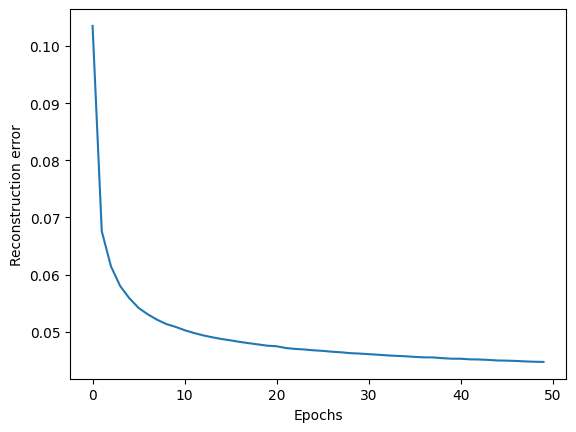

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

Evaluate on the Test Set
-------------------------

In [ ]:
# set to evaluation mode
autoencoder.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:

    with torch.no_grad():

        image_batch = image_batch.to(device) # putting image_batch on GPU

        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch) # forward propagation on autoencoder

        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch) # computing MSE reconstruction loss

        test_loss_avg += loss.item()
        num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.046519


Visualize Reconstructions
--------------------------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

autoencoder.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

Original images


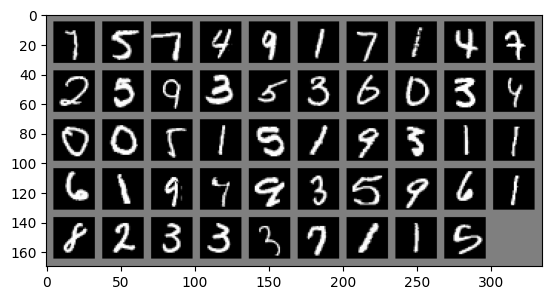

Autoencoder reconstruction:


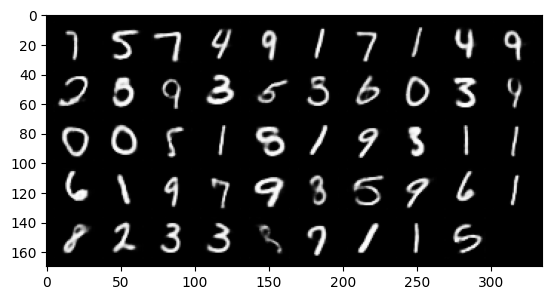

In [ ]:
images, labels = next(iter(test_dataloader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, autoencoder)

Interpolate in Latent Space
----------------------------

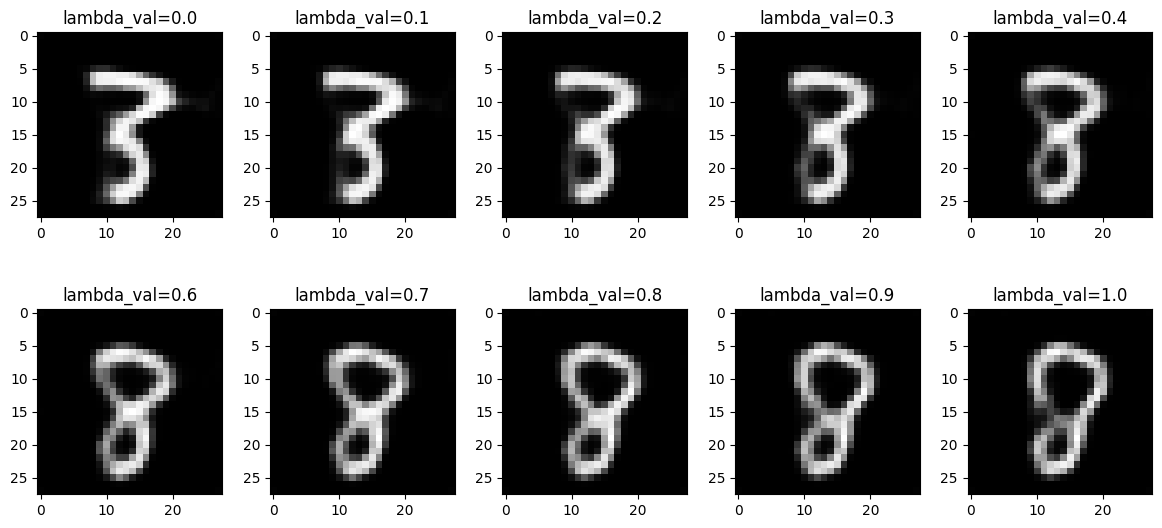

In [ ]:
autoencoder.eval()

def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        latent_1 = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2 = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

    return inter_image

# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    #inter_image=interpolation(float(l), autoencoder, digits[7][0], digits[1][0])
    #inter_image=interpolation(float(l), autoencoder, digits[9][0], digits[4][0])
    inter_image=interpolation(float(l), autoencoder, digits[8][0], digits[3][0])

    inter_image = to_img(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))

plt.show()